Importing packages:

In [7]:
pip install segyio

Note: you may need to restart the kernel to use updated packages.


In [49]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("seaborn")
from skimage.io import imsave, imread
import pandas as pd

In [50]:
import os
os.chdir('/media/paulina/My Passport/NRCan/data/PRAISE_Lithoprobe/')

Reading the seismic data - example:

Further manipulations as described in https://github.com/equinor/segyio-notebooks/blob/master/notebooks/basic/02_segy_quicklook.ipynb

In [51]:
import re

def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the segy file trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    One row per trace
    '''
    # Get all header keys
    headers = segyio.tracefield.keys
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces + 1),
                      columns=headers.keys())
    # Fill dataframe with all header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
    return df

def parse_text_header(segyfile):
    '''
    Format segy text header into a readable, clean dict
    '''
    raw_header = segyio.tools.wrap(segyfile.text[0])
    # Cut on C*int pattern
    cut_header = re.split(r'C ', raw_header)[1::]
    # Remove end of line return
    text_header = [x.replace('\n', ' ') for x in cut_header]
    text_header[-1] = text_header[-1][:-2]
    # Format in dict
    clean_header = {}
    i = 1
    for item in text_header:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        clean_header[key] = item
    return clean_header

In [52]:
fseis = "L11a.sgy"
with segyio.open(fseis, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) /1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

'N Traces: 4624, N Samples: 4501, Sample rate: 4.0ms'

Let's use trace header from the SEGY file to access the necessary coordinates

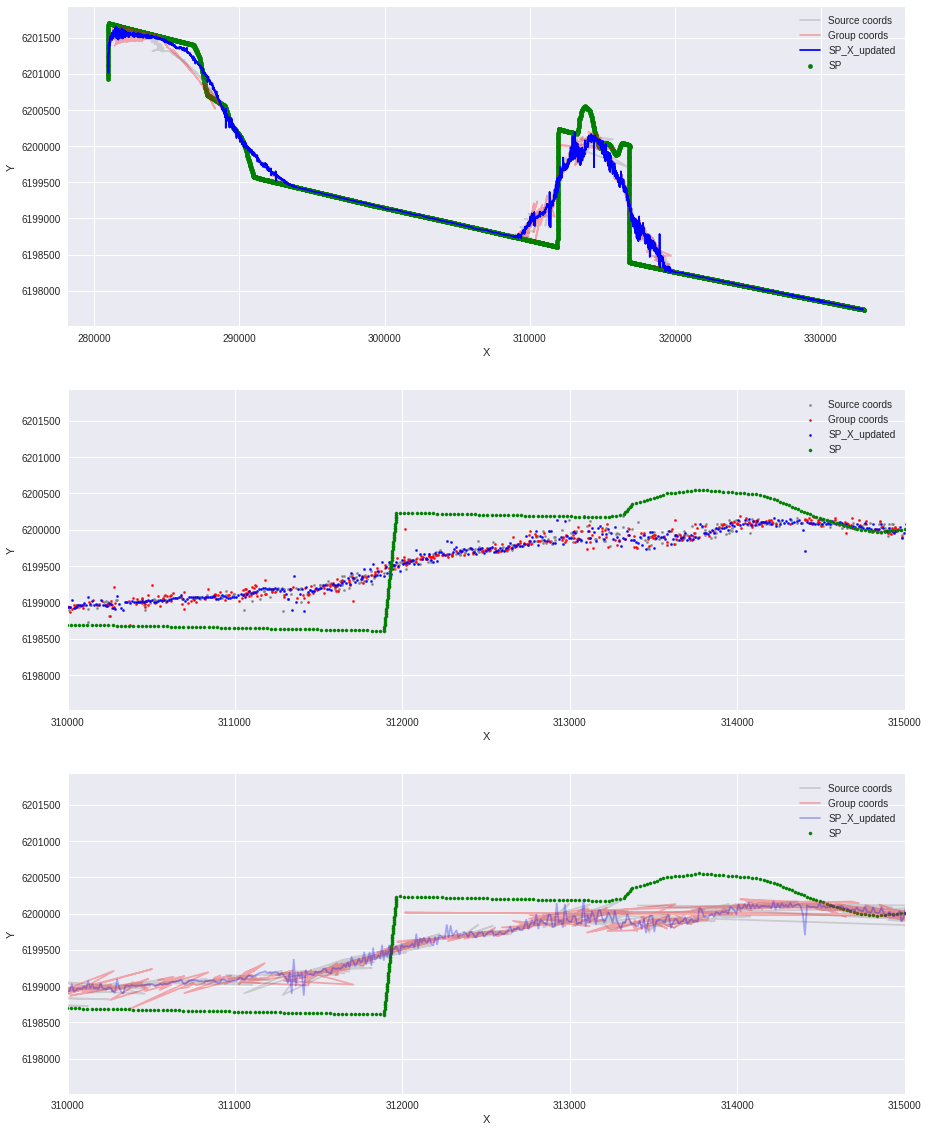

In [53]:
coords_df = pd.read_csv('txt_files/OpendTect/line_11.txt', header=None, sep=" ", names=['SP','X','Y'])

trace_headers["SourceX_updated"] = trace_headers["SourceDepth"] / 100


mul_coef = (trace_headers['CDP'].iloc[-1] - trace_headers['CDP'].iloc[0]) / (coords_df['SP'].iloc[-1] - coords_df['SP'].iloc[0])
mul_coef

first_tr_index = trace_headers['CDP'].iloc[0]

coords_df["SP_index"] = coords_df.index
coords_df["Tr_index_interp"] = first_tr_index + coords_df["SP_index"] * mul_coef
coords_df["Tr_index_interp_int"] = coords_df["Tr_index_interp"].astype(int)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,20))
ax2.set_xlim(310000,315000)
ax3.set_xlim(310000,315000)

x1 = trace_headers.plot.line(x='SourceX', y='SourceY', c='grey',ax = ax1, alpha=0.3, label="Source coords")
x2 = trace_headers.plot.line(x='GroupX', y='GroupY', c='Red',ax = ax1, alpha=0.3, label="Group coords")
x3 = trace_headers.plot.line(x='SourceX_updated', y='SourceY', c='blue',ax = ax1, label="SP_X_updated")
x4 = coords_df.plot.scatter(x = 'X', y="Y", c="g", ax=ax1, label="SP")

x1 = trace_headers.plot.scatter(x='SourceX', y='SourceY', c='grey',ax = ax2,s=5, label="Source coords")
x2 = trace_headers.plot.scatter(x='GroupX', y='GroupY', c='Red',ax = ax2,s=5,label="Group coords")
x3 = trace_headers.plot.scatter(x='SourceX_updated', y='SourceY', c='blue',ax = ax2,s=5, label="SP_X_updated")
x4 = coords_df.plot.scatter(x = 'X', y="Y", c="g", ax=ax2, s=10, label="SP")

x1 = trace_headers.plot.line(x='SourceX', y='SourceY', c='grey',ax = ax3,alpha=0.3, label="Source coords")
x2 = trace_headers.plot.line(x='GroupX', y='GroupY', c='Red',ax = ax3, alpha=0.3, label="Group coords")
x3 = trace_headers.plot.line(x='SourceX_updated', y='SourceY', c='blue', ax = ax3,alpha=0.3, label="SP_X_updated")
x4 = coords_df.plot.scatter(x = 'X', y="Y", c="g", ax=ax3, s=10, label="SP")



plt.show()


# trace_headers_valid[["GroupX","SourceX", "SourceX_v2"]].head()

We see that the coordinates from column Source_X_updated gives us the best results. We can import the coordinates from the SEGP1 file, however they give the location of the shotpoint. 

In [54]:
coords_df = pd.read_csv('txt_files/OpendTect/line_11.txt', header=None, sep=" ", names=['SP','X','Y'])

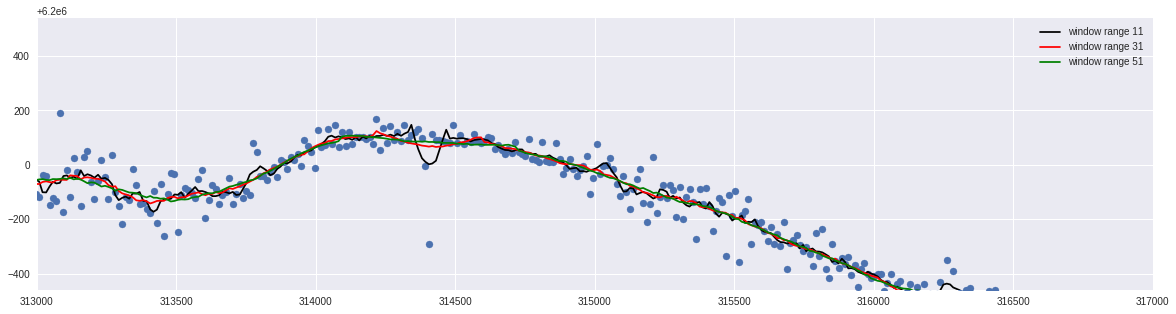

In [55]:
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt

xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY"]

fig, ax = plt.subplots(figsize=(20,5))

ax.set_xlim(313000,317000)
ax.set_ylim(6199540.072819445, 6200540)
colors = ['red','green','black']
windows = range(11, 101,20)

for i in range(0, len(colors)):
    yhat = savgol_filter(ys, windows[i], 3) # window size 51, polynomial order 3
    ax.plot(xs,yhat, color=colors[i-1], label="window range " + str(windows[i]))

ax.legend()
ax.scatter(xs, ys)
plt.show()


We decide to use the window size 51 as that approximates well the scatter CDP plots, producing nice, smooth line.

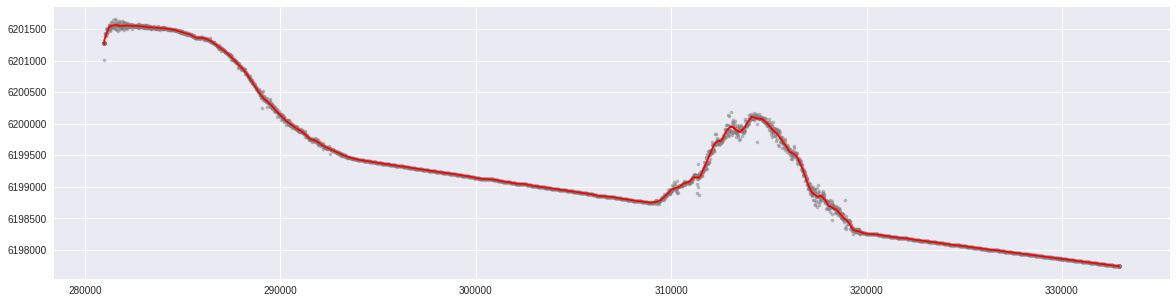

In [56]:
fig, ax = plt.subplots(figsize=(20,5))

xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY"]

yhat = savgol_filter(ys, 51, 3) 

ax.scatter(xs, ys, s=10, c='grey', alpha=0.5)
ax.plot(xs, yhat,c='red');


Export the results to dataframe

In [57]:
frame = {'Trace_number':xs.index, 'X_new': xs, 'Y_new': yhat} 
# new_df[['Trace_number','X_new','Y_new']].to_csv("/media/paulina/My Passport/NRCan/data/PRAISE_Lithoprobe/txt_files/geometry/11A_smoothed_geometry.txt", index = False, header=False, sep = ' ')

Work on the next line: L11b.segy

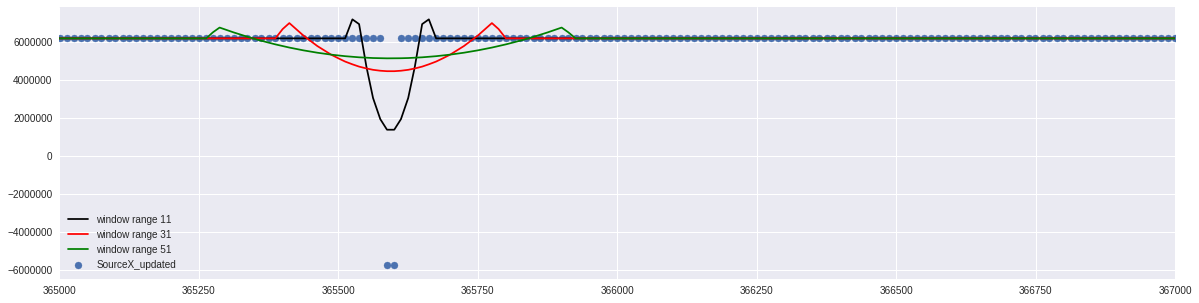

In [58]:
fseis = "L11b.sgy"
with segyio.open(fseis, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) /1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

trace_headers["SourceX_updated"] = trace_headers["SourceDepth"] / 100
# idx_to_update = trace_headers[trace_headers["SourceY"] < 0].index
# trace_headers.apply(lambda: x = x*(-1) if trace_headers["SourceY"] < 0 )

# trace_headers['SourceY'].mask(trace_headers['SourceY'] < 0, trace_headers['SourceY']*(-1))
# print(list(idx_to_update))

# df.at[1,'SourceY']=50

# df.loc[df.filename == 'test2.dat', 'n'] = df2[df2.filename == 'test2.dat'].loc[0]['n']
# trace_headers["SourceY"].min()
xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY"]

fig, ax = plt.subplots(figsize=(20,5))

ax.set_xlim(365000, 367000)
# ax.set_ylim(6199540.072819445, 6200540)
colors = ['red','green','black']
windows = range(11, 101,20)

for i in range(0, len(colors)):
    yhat = savgol_filter(ys, windows[i], 3) # window size 51, polynomial order 3
    ax.plot(xs,yhat, color=colors[i-1], label="window range " + str(windows[i]))

ax.scatter(xs, ys, label="SourceX_updated")
ax.legend()

plt.show()


There's a problem with a few data points, we can check that there are 2 points with negative values of the y coordinate:

In [59]:
sum(trace_headers["SourceY"] < 0)
trace_headers[trace_headers["SourceY"] < 0]["SourceY"]

3030   -5738060
3031   -5737873
Name: SourceY, dtype: int32

It's completely wrong. We need to interpolate the value based on the other points in the vicinity.

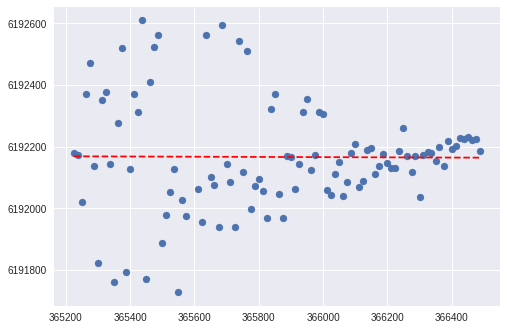

In [60]:
# fit a second degree polynomial to the data
from numpy import arange
from scipy.optimize import curve_fit
 
# define the true objective function
def objective(x, a, b):
    return a * x + b

# choose the input and output variables
df_interp = trace_headers[trace_headers["SourceY"] > 0]
x = df_interp["SourceX_updated"][3000:3100]
y = df_interp["SourceY"][3000:3100]

# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b = popt
# print('y = %.5f * x + %.5f * x' % (a, b))
# plot input vs output
plt.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b)
# create a line plot for the mapping function
plt.plot(x_line, y_line, '--', color='red')
# plt.show()
frame = {"SourceX_updated":x_line, "SourceY_updated":y_line}
dataframe = pd.DataFrame(frame)
wrong_coords = trace_headers[trace_headers["SourceY"] < 0]["SourceX_updated"]

trace_headers["SourceY_updated"] = trace_headers["SourceY"]

ynew_3030 = dataframe[dataframe["SourceX_updated"] == wrong_coords.to_list()[0]]["SourceY_updated"]
ynew_3031 = dataframe[dataframe["SourceX_updated"] == wrong_coords.to_list()[1]]["SourceY_updated"]

trace_headers.at[3030, "SourceY_updated"] = ynew_3030
trace_headers.at[3031, "SourceY_updated"] = ynew_3031

Let's plot it again - outliers fixed

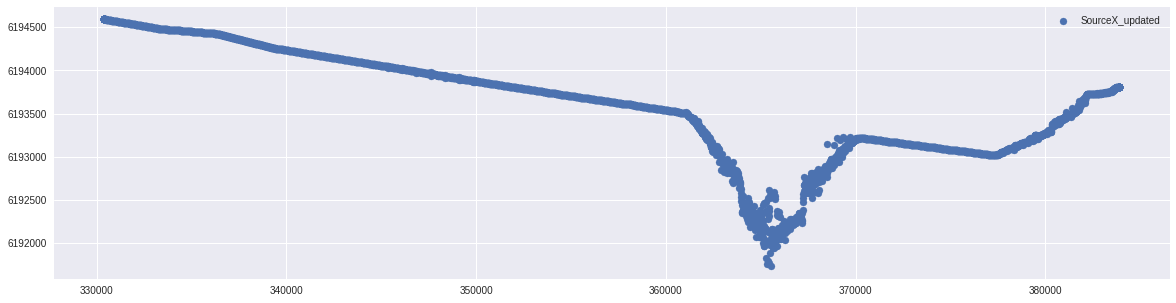

In [61]:
xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY_updated"]

fig, ax = plt.subplots(figsize=(20,5))

# ax.set_xlim(365000, 367000)
# ax.set_ylim(6199540.072819445, 6200540)
colors = ['red','green','black']
windows = range(11, 101,20)

# for i in range(0, len(colors)):
#     yhat = savgol_filter(ys, windows[i], 3) # window size 51, polynomial order 3
#     ax.plot(xs,yhat, color=colors[i-1], label="window range " + str(windows[i]))

ax.scatter(xs, ys, label="SourceX_updated")
ax.legend()

plt.show()

Now we can fit the smoothed curve. Lets increase the smoothing to 101 as the CDP coordinates are pretty scattered around X = 3650000

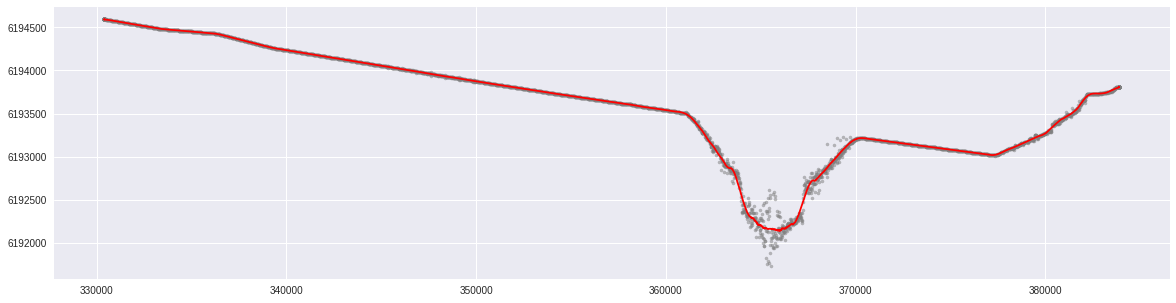

In [62]:
fig, ax = plt.subplots(figsize=(20,5))

xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY_updated"]

yhat = savgol_filter(ys, 101, 3) 

ax.scatter(xs, ys, s=10, c='grey', alpha=0.5)
ax.plot(xs, yhat,c='red');

Export the updated coordinates

In [63]:
frame = {'Trace_number':xs.index, 'X_new': xs, 'Y_new': yhat} 
new_df = pd.DataFrame(frame)
# new_df[['Trace_number','X_new','Y_new']].to_csv("/media/paulina/My Passport/NRCan/data/PRAISE_Lithoprobe/txt_files/geometry/11B_smoothed_geometry.txt", index = False, header=False, sep = ' ')

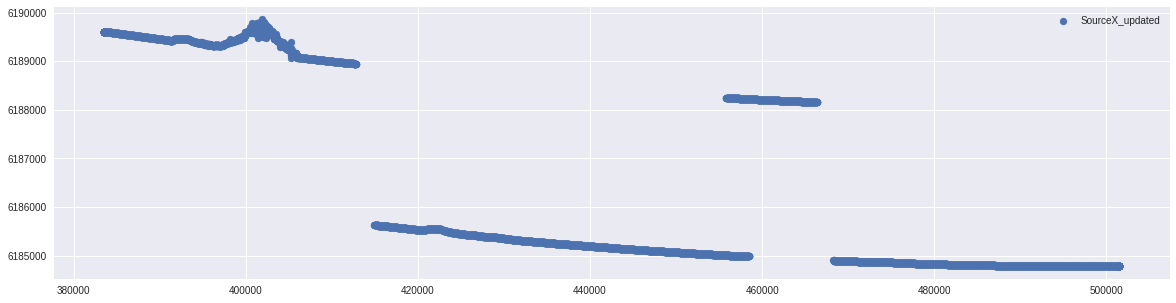

In [64]:
fseis = "L12.sgy"
with segyio.open(fseis, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) /1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

trace_headers["SourceX_updated"] = trace_headers["SourceDepth"] / 100

xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY"]

fig, ax = plt.subplots(figsize=(20,5))

# ax.set_xlim(380000, 410000)
# ax.set_ylim(6189040.072819445, 6190540)
colors = ['red','green','black']
windows = range(11, 101,20)

# for i in range(0, len(colors)):
#     yhat = savgol_filter(ys, windows[i], 3) # window size 51, polynomial order 3
#     ax.plot(xs,yhat, color=colors[i-1], label="window range " + str(windows[i]))

ax.scatter(xs, ys, label="SourceX_updated")
ax.legend()

plt.show()


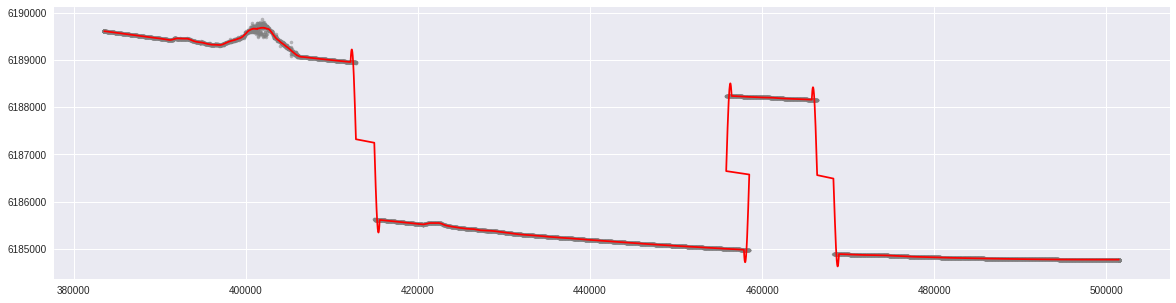

In [65]:
fig, ax = plt.subplots(figsize=(20,5))

xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY"]

yhat = savgol_filter(ys, 101, 3) 

ax.scatter(xs, ys, s=10, c='grey', alpha=0.5)
ax.plot(xs, yhat,c='red');

In [66]:
frame = {'Trace_number':xs.index, 'X_new': xs, 'Y_new': yhat} 
new_df = pd.DataFrame(frame)
# new_df[['Trace_number','X_new','Y_new']].to_csv("/media/paulina/My Passport/NRCan/data/PRAISE_Lithoprobe/txt_files/geometry/12AB_smoothed_geometry.txt", index = False, header=False, sep = ' ')

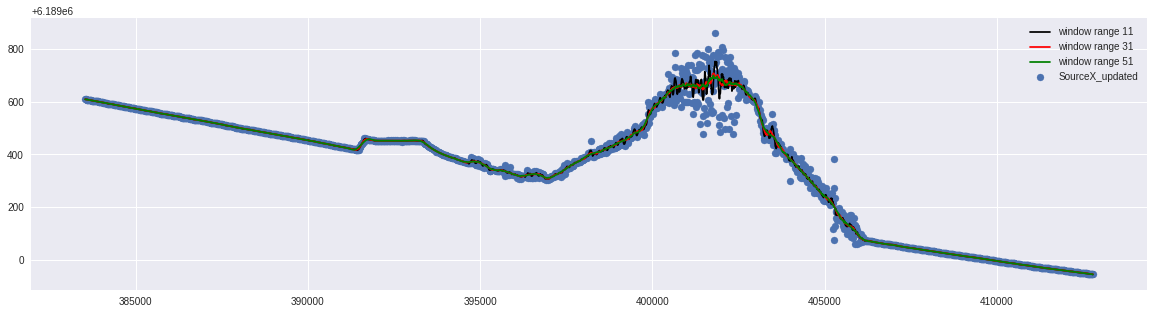

In [67]:
fseis = "L12ab.sgy"
with segyio.open(fseis, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) /1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

trace_headers["SourceX_updated"] = trace_headers["SourceDepth"] / 100

xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY"]

fig, ax = plt.subplots(figsize=(20,5))

# ax.set_xlim(380000, 410000)
# ax.set_ylim(6189040.072819445, 6190540)
colors = ['red','green','black']
windows = range(11, 101,20)

for i in range(0, len(colors)):
    yhat = savgol_filter(ys, windows[i], 3) # window size 51, polynomial order 3
    ax.plot(xs,yhat, color=colors[i-1], label="window range " + str(windows[i]))

ax.scatter(xs, ys, label="SourceX_updated")
ax.legend()

plt.show()


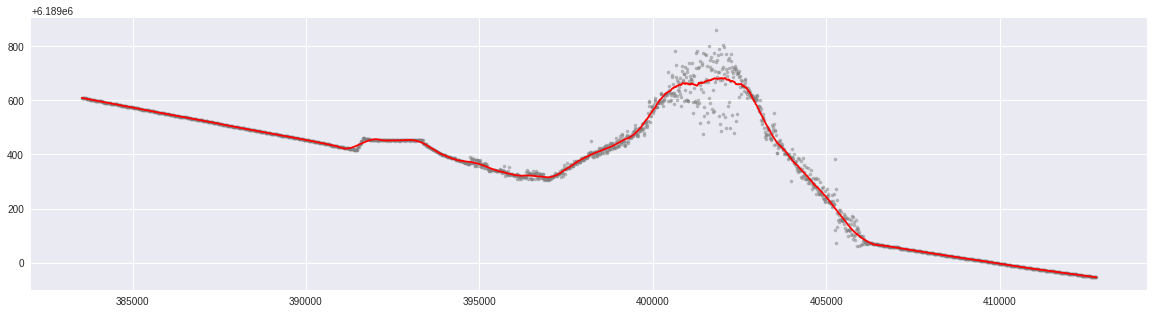

In [68]:
fig, ax = plt.subplots(figsize=(20,5))

xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY"]

yhat = savgol_filter(ys, 101, 3) 

ax.scatter(xs, ys, s=10, c='grey', alpha=0.5)
ax.plot(xs, yhat,c='red');

In [69]:
frame = {'Trace_number':xs.index, 'X_new': xs, 'Y_new': yhat} 
new_df = pd.DataFrame(frame)
# new_df[['Trace_number','X_new','Y_new']].to_csv("/media/paulina/My Passport/NRCan/data/PRAISE_Lithoprobe/txt_files/geometry/12AB_smoothed_geometry.txt", index = False, header=False, sep = ' ')

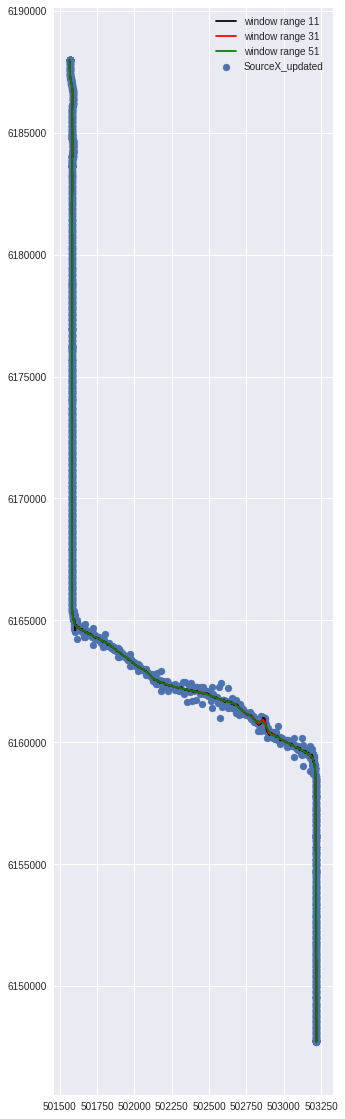

In [70]:
fseis = "L13(1).sgy"
with segyio.open(fseis, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) /1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

trace_headers["SourceX_updated"] = trace_headers["SourceDepth"] / 100

xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY"]

fig, ax = plt.subplots(figsize=(5,20))

# ax.set_xlim(380000, 410000)
# ax.set_ylim(6189040.072819445, 6190540)
colors = ['red','green','black']
windows = range(11, 101,20)

for i in range(0, len(colors)):
    yhat = savgol_filter(ys, windows[i], 3) # window size 51, polynomial order 3
    ax.plot(xs,yhat, color=colors[i-1], label="window range " + str(windows[i]))

ax.scatter(xs, ys, label="SourceX_updated")
ax.legend()

plt.show()

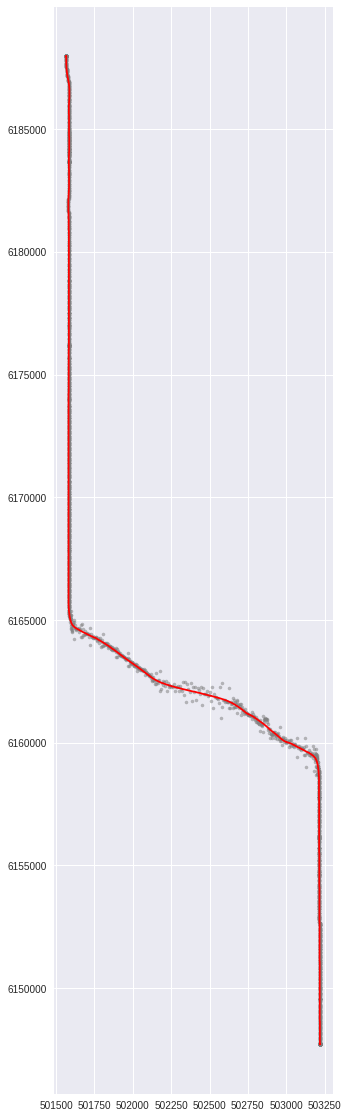

In [71]:
fig, ax = plt.subplots(figsize=(5,20))

xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY"]

yhat = savgol_filter(ys, 101, 3) 

ax.scatter(xs, ys, s=10, c='grey', alpha=0.5)
ax.plot(xs, yhat,c='red');

In [72]:
frame = {'Trace_number':xs.index, 'X_new': xs, 'Y_new': yhat} 
new_df = pd.DataFrame(frame)
new_df[['Trace_number','X_new','Y_new']].to_csv("/media/paulina/My Passport/NRCan/data/PRAISE_Lithoprobe/txt_files/geometry/13_smoothed_geometry.txt", index = False, header=False, sep = ' ')

In [73]:
!ls

 All_traces_line11a.csv		     L14c.sgy
 header_100traces_line11a.csv	     L15.sgy
 L11a.sgy			     L16.sgy
 L11b_fixed.sgy			     L17.sgy
 L11b.sgy			     L18.sgy
 L11b_TOMOKO.sgy		     L19.sgy
 L12ab.sgy			    'L20a(1).sgy'
 L12cd.sgy			    'L20b(2).sgy'
 L12F.sgy			     picks_from_OpendTect
 l12_segp1_coords_calculation.xlsx   shapefiles_lithoprobe
 L12.sgy			     Shotpoints_line11a.csv
'L13(1).sgy'			     txt_files
'L14ab(1).sgy'


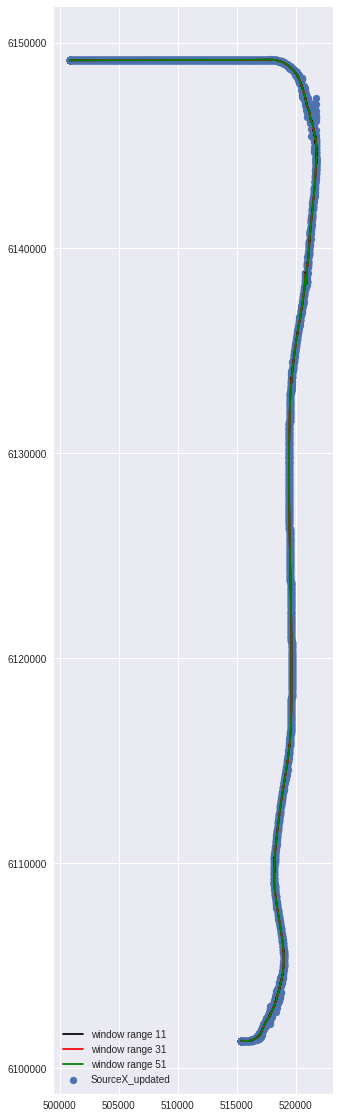

In [80]:
fseis = "L14ab(1).sgy"
with segyio.open(fseis, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) /1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

trace_headers["SourceX_updated"] = trace_headers["SourceDepth"] / 100

xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY"]

fig, ax = plt.subplots(figsize=(5,20))

# ax.set_xlim(380000, 410000)
# ax.set_ylim(6140000, 6159000,)
colors = ['red','green','black']
windows = range(11, 101,20)

for i in range(0, len(colors)):
    yhat = savgol_filter(ys, windows[i], 3) # window size 51, polynomial order 3
    ax.plot(xs,yhat, color=colors[i-1], label="window range " + str(windows[i]))

ax.scatter(xs, ys, label="SourceX_updated")
ax.legend()

plt.show()

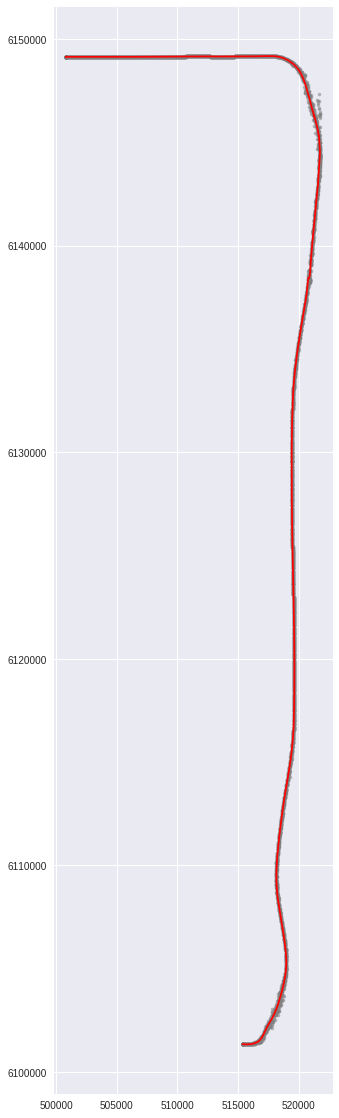

In [81]:
fig, ax = plt.subplots(figsize=(5,20))

xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY"]

yhat = savgol_filter(ys, 101, 3) 

ax.scatter(xs, ys, s=10, c='grey', alpha=0.5)
ax.plot(xs, yhat,c='red');

In [82]:
frame = {'Trace_number':xs.index, 'X_new': xs, 'Y_new': yhat} 
new_df = pd.DataFrame(frame)
new_df.head()
# new_df[['Trace_number','X_new','Y_new']].to_csv("/media/paulina/My Passport/NRCan/data/PRAISE_Lithoprobe/txt_files/geometry/14ab_smoothed_geometry.txt", index = False, header=False, sep = ' ')

,Trace_number,X_new,Y_new
1,1,500837.0,6149152.0
2,2,500837.0,6149152.0
3,3,500837.0,6149152.0
4,4,500837.0,6149152.0
5,5,500837.0,6149152.0


#### using ccooords from NRCan website as the seismic one is strange

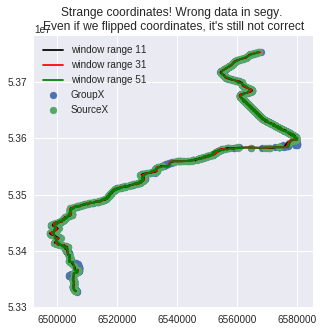

In [91]:
fseis = "L14c.sgy"
with segyio.open(fseis, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) /1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

# print(trace_headers[['SourceX', 'SourceY', 'GroupX', 'GroupY']].head())
# print(trace_headers.columns)
xs = trace_headers["SourceX"]
ys = trace_headers["SourceY"]

fig, ax = plt.subplots(figsize=(5,5))

# ax.set_xlim(380000, 410000)
# ax.set_ylim(6189040.072819445, 6190540)
colors = ['red','green','black']
windows = range(11, 101,20)

for i in range(0, len(colors)):
    xhat = savgol_filter(xs, windows[i], 3) # window size 51, polynomial order 3
    ax.plot(xhat,ys, color=colors[i-1], label="window range " + str(windows[i]))

ax.scatter(trace_headers['GroupX'], trace_headers['GroupY'], label="GroupX")
# ax.scatter(trace_headers['GroupX'], trace_headers['GroupY'], label="GroupX")

ax.scatter(xs, ys, label="SourceX")
ax.legend()
ax.set_title('Strange coordinates! Wrong data in segy. \nEven if we flipped coordinates, it\'s still not correct')

plt.show()

Line 14c had incorrect coordinates in the segy file, so let's use the ones from the NRCan website (nrcanCoords14c

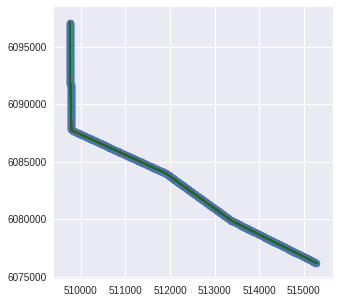

In [92]:
nrcanCoords14c = pd.read_csv('/media/paulina/My Passport/NRCan/data/PRAISE_Lithoprobe/txt_files/OpendTect/line_14C.txt', 
                         sep=' ', skiprows=0, header=None, names=['TraceNr','Easting','Northing'])
nrcanCoords14c.head()

colors = ['red','green','black']
windows = range(11, 101,20)

xsnrcan = nrcanCoords14c["Easting"]
ysnrcan = nrcanCoords14c["Northing"]

fig, ax = plt.subplots(figsize=(5,5))

for i in range(0, len(colors)):
    xhat = savgol_filter(xsnrcan, windows[i], 3) # window size 51, polynomial order 3
    ax.plot(xhat,ysnrcan, color=colors[i-1], label="window range " + str(windows[i]))
    
ax.scatter(xsnrcan, ysnrcan, label="SourceX")
plt.show()

# nrcanCoords14c[['TraceNr','Easting', 'Northing']].to_csv("/media/paulina/My Passport/NRCan/data/PRAISE_Lithoprobe/txt_files/geometry/14c_smoothed_geometry.txt", index = False, header=False, sep = ' ')

In [ ]:
frame = {'Trace_number':xs.index, 'X_new': xhat-500000, 'Y_new': ys} 
new_df = pd.DataFrame(frame)
new_df.head()
# new_df[['Trace_number','X_new', 'Y_new']].to_csv("/media/paulina/My Passport/NRCan/data/PRAISE_Lithoprobe/txt_files/geometry/14c_smoothed_geometry.txt", index = False, header=False, sep = ' ')

In [ ]:
fseis = "L12cd.sgy"
with segyio.open(fseis, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) /1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

trace_headers["SourceX_updated"] = trace_headers["SourceDepth"] / 100
# idx_to_update = trace_headers[trace_headers["SourceY"] < 0].index
# trace_headers.apply(lambda: x = x*(-1) if trace_headers["SourceY"] < 0 )

# trace_headers['SourceY'].mask(trace_headers['SourceY'] < 0, trace_headers['SourceY']*(-1))
# print(list(idx_to_update))

# df.at[1,'SourceY']=50

# df.loc[df.filename == 'test2.dat', 'n'] = df2[df2.filename == 'test2.dat'].loc[0]['n']
# trace_headers["SourceY"].min()
xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY"]

fig, ax = plt.subplots(figsize=(20,5))

# ax.set_xlim(380000, 410000)
# ax.set_ylim(6189040.072819445, 6190540)
colors = ['red','green','black']
windows = range(11, 101,20)

for i in range(0, len(colors)):
    yhat = savgol_filter(ys, windows[i], 3) # window size 51, polynomial order 3
    ax.plot(xs,yhat, color=colors[i-1], label="window range " + str(windows[i]))

ax.scatter(xs, ys, label="SourceX_updated")
ax.legend()

plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(20,5))

xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY"]

yhat = savgol_filter(ys, 51, 3) 

ax.scatter(xs, ys, s=10, c='grey', alpha=0.5)
ax.plot(xs, yhat,c='red');

In [ ]:
frame = {'Trace_number':xs.index, 'X_new': xs, 'Y_new': yhat} 
new_df = pd.DataFrame(frame)
# new_df[['Trace_number','X_new','Y_new']].to_csv("/media/paulina/My Passport/NRCan/data/PRAISE_Lithoprobe/txt_files/geometry/12CD_smoothed_geometry.txt", index = False, header=False, sep = ' ')

In [ ]:
fseis = "L12F.sgy"
with segyio.open(fseis, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) /1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

trace_headers["SourceX_updated"] = trace_headers["SourceDepth"] / 100

xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY"]

fig, ax = plt.subplots(figsize=(20,5))

# ax.set_xlim(380000, 410000)
# ax.set_ylim(6189040.072819445, 6190540)
colors = ['red','green','black']
windows = range(11, 101,20)

for i in range(0, len(colors)):
    yhat = savgol_filter(ys, windows[i], 3) # window size 51, polynomial order 3
    ax.plot(xs,yhat, color=colors[i-1], label="window range " + str(windows[i]))

ax.scatter(xs, ys, label="SourceX_updated")
ax.legend()

plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(20,5))

xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY"]

yhat = savgol_filter(ys, 101, 3) 

ax.scatter(xs, ys, s=10, c='grey', alpha=0.5)
ax.plot(xs, yhat,c='red');

In [ ]:
frame = {'Trace_number':xs.index, 'X_new': xs, 'Y_new': yhat} 
new_df = pd.DataFrame(frame)
# new_df[['Trace_number','X_new','Y_new']].to_csv("/media/paulina/My Passport/NRCan/data/PRAISE_Lithoprobe/txt_files/geometry/12F_smoothed_geometry.txt", index = False, header=False, sep = ' ')

In [ ]:
from IPython.display import Image
Image(filename='/home/paulina/Desktop/for_DAVE/Lithoprobe_fixed.png') 

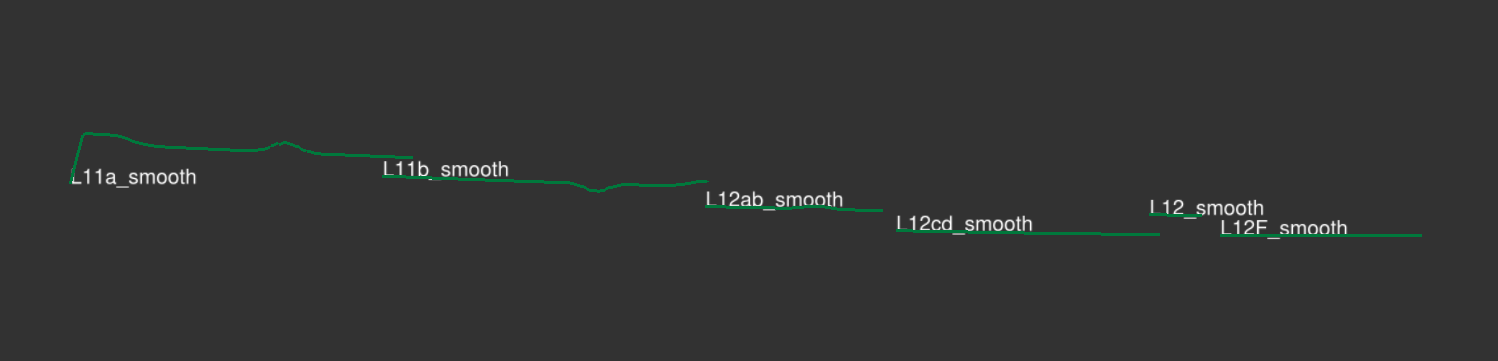

In [37]:
Image(filename='/home/paulina/Desktop/for_DAVE/Lithoprobe_fixed_zview.png') 

In [39]:
#14ab
!ls
fseis = "L14ab.sgy"
with segyio.open(fseis, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) /1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

trace_headers["SourceX_updated"] = trace_headers["SourceDepth"] / 100

xs = trace_headers["SourceX_updated"]
ys = trace_headers["SourceY"]

fig, ax = plt.subplots(figsize=(20,5))

# ax.set_xlim(380000, 410000)
# ax.set_ylim(6189040.072819445, 6190540)
colors = ['red','green','black']
windows = range(11, 101,20)

for i in range(0, len(colors)):
    yhat = savgol_filter(ys, windows[i], 3) # window size 51, polynomial order 3
    ax.plot(xs,yhat, color=colors[i-1], label="window range " + str(windows[i]))

ax.scatter(xs, ys, label="SourceX_updated")
ax.legend()

plt.show()


 All_traces_line11a.csv		     L14c.sgy
 header_100traces_line11a.csv	     L15.sgy
 L11a.sgy			     L16.sgy
 L11b_fixed.sgy			     L17.sgy
 L11b.sgy			     L18.sgy
 L11b_TOMOKO.sgy		     L19.sgy
 L12ab.sgy			    'L20a(1).sgy'
 L12cd.sgy			    'L20b(2).sgy'
 L12F.sgy			     picks_from_OpendTect
 l12_segp1_coords_calculation.xlsx   shapefiles_lithoprobe
 L12.sgy			     Shotpoints_line11a.csv
'L13(1).sgy'			     txt_files
'L14ab(1).sgy'


FileNotFoundError: [Errno 2] No such file or directory

In [55]:
bin_headers

{JobID: 0, LineNumber: 0, ReelNumber: 1, Traces: 0, AuxTraces: 0, Interval: 4000, IntervalOriginal: 0, Samples: 4501, SamplesOriginal: 0, Format: 1, EnsembleFold: 0, SortingCode: 0, VerticalSum: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 0, MeasurementSystem: 0, ImpulseSignalPolarity: 0, VibratoryPolarity: 0, ExtAuxTraces: 0, ExtSamples: 0, ExtSamplesOriginal: 0, ExtEnsembleFold: 0, SEGYRevision: 0, SEGYRevisionMinor: 0, TraceFlag: 0, ExtendedHeaders: 0}

In [56]:
text_headers

{'C01': 'ANOM.: WORD 18 (SEGY 197) .C21 .C22 .C23 .C24 .C25 .C26 .C27 .C28 .C29 .C30 .C31 .C32 .C33 .C34 .C35 .C36 .C37 .C38 .C39 .C40 END EBCDIC'}

Text(0.5, 1.0, 'L12F.sgy')

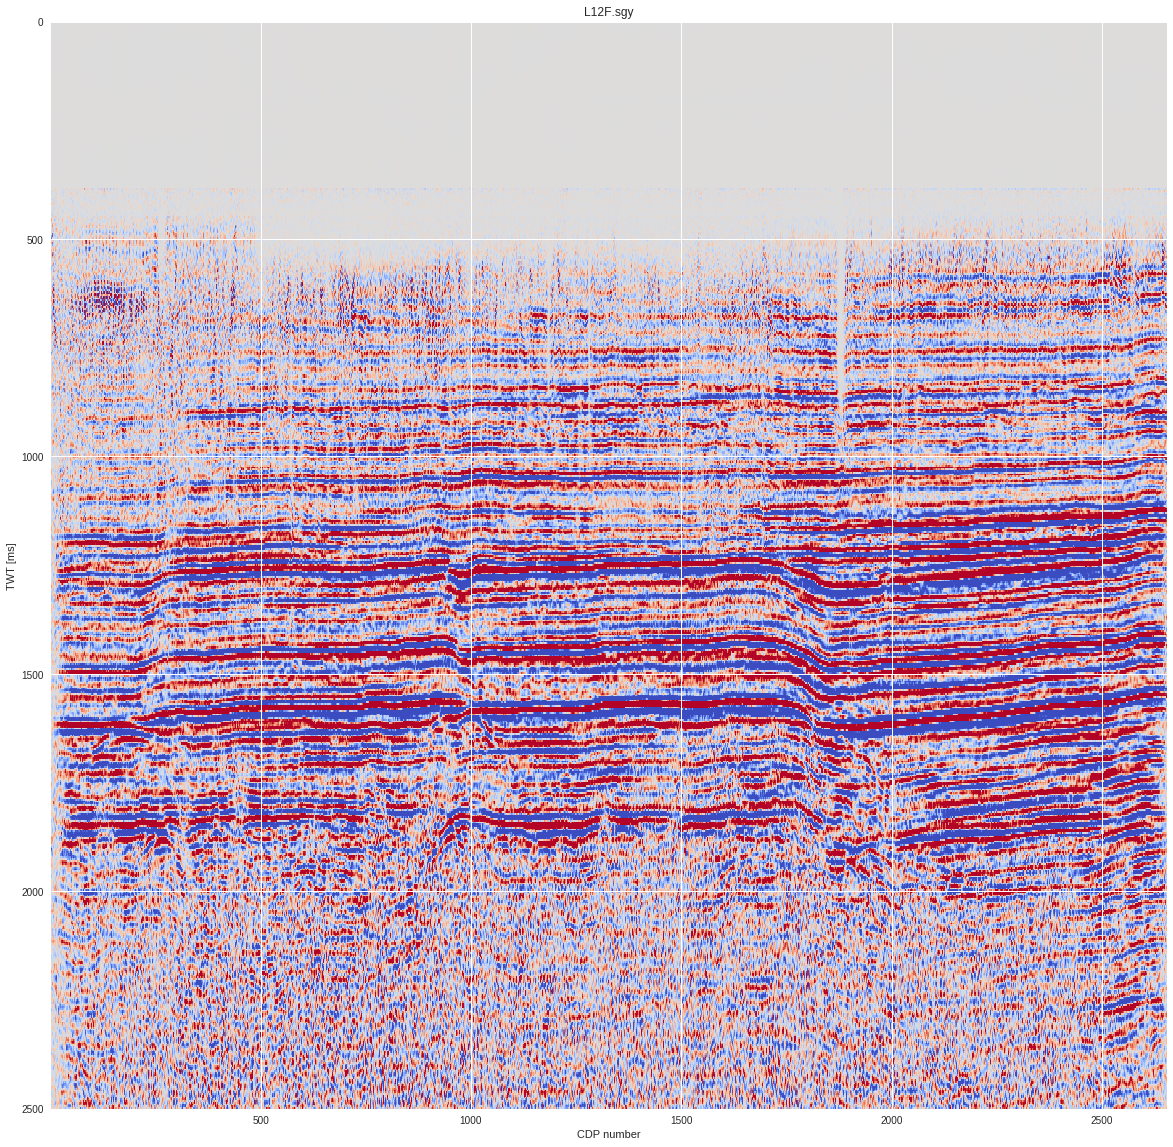

In [57]:
clip_percentile = 95
vm = np.percentile(data, clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}'

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)
extent = [1, n_traces, twt[-1], twt[0]]  # define extent
ax.imshow(data.T, cmap="coolwarm", vmin=-vm, vmax=vm, aspect='auto', extent=extent)
ax.set_xlabel('CDP number')
ax.set_ylabel('TWT [ms]')
ax.set_ylim(2500, 0)
ax.set_title(f'{fseis}')

# fig.savefig('L11a_pictureab.jpg', dpi=300)

### Visualize all the lines

file list ['12CD_smoothed_geometry.txt', '11A_smoothed_geometry.txt', '11B_smoothed_geometry.txt', '12AB_smoothed_geometry.txt', '12F_smoothed_geometry.txt', '12_smoothed_geometry.txt', '13_smoothed_geometry.txt', '14ab_smoothed_geometry.txt', '14c_smoothed_geometry.txt']


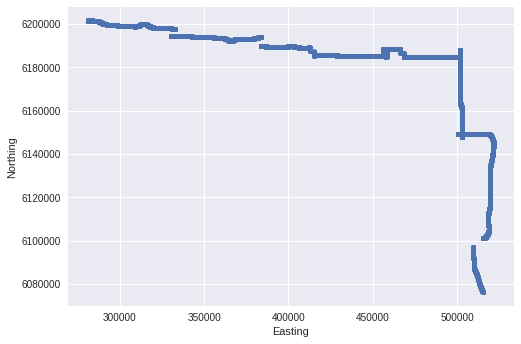

In [309]:
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd

os.chdir('/media/paulina/My Passport/NRCan/data/PRAISE_Lithoprobe/txt_files/geometry')
file_list = glob.glob('*smoothed_geometry.txt')
# file_list = ['11A_smoothed_geometry.txt', '11B_smoothed_geometry.txt', '12AB_smoothed_geometry.txt', 
#              '12CD_smoothed_geometry.txt', '12F_smoothed_geometry.txt', '12_smoothed_geometry.txt', '13_smoothed_geometry.txt']

# file_list = ['14ab_smoothed_geometry.txt', '14c_smoothed_geometry.txt']
print(f'file list {file_list}')

lines_all = pd.DataFrame({'TraceNr':[],
                             'Easting':[],
                             'Northing':[],
                          'Line_num':[]})
# merge the lines
for file in file_list:
    line_num = file.split(sep='_')[0]
    line_raw = pd.read_csv(file, sep=' ', header=None, names=['TraceNr','Easting','Northing'])
    line_raw['Line_num'] = line_num
    lines_all = lines_all.append(line_raw)
    line_geom = gpd.GeoDataFrame(
        lines_all, geometry=gpd.points_from_xy(lines_all.Easting, lines_all.Northing))
# line_geom.plot() 
line_geom[line_geom['Line_num'] == '14ab']
ax = lines_all.plot(x = 'Easting', y='Northing',kind='scatter')

# line_geom.to_file(filename = './merged_smoothed_lines11-14.geojson', driver = 'GeoJSON')# import contextily as ctx
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)


NameError: name 'line_geom' is not defined

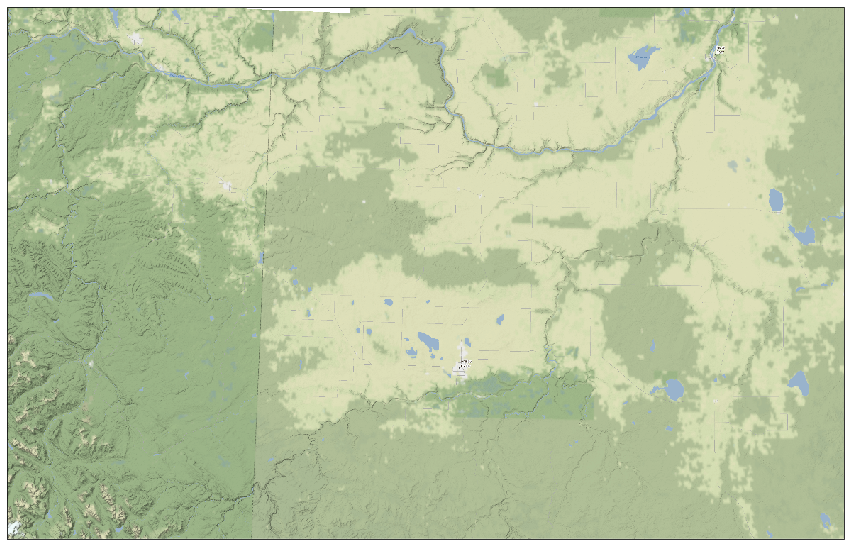

In [2]:
### CartoPy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from cartopy.io.img_tiles import Stamen

def main():
#     tiler = Stamen('terrain-background') #terrain
    tiler = Stamen('terrain') 
#     mercator = tiler.crs
    proj = ccrs.epsg(26911)
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.set_extent([208055,531071,6050000,6251922], crs=ccrs.UTM(zone=11))

    ax.add_image(tiler, 10)
    ax.scatter(line_geom.Easting, line_geom.Northing, s=1)
    line_geom.plot(ax=ax)
#     ax.grid(which='major',axis='both')

#     ax.coastlines('10m')
    plt.show()


if __name__ == '__main__':
    main()


# ax = lines_all.plot(x = 'Easting', y='Northing',kind='scatter')
# ax.add_image(tiler)